predicted_label은 text와 label을 분석하여 산출하고 Bert_Sentiment는 text

In [4]:
import pandas as pd
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline

import numpy as np
import time
from matplotlib import rcParams
# 한글 폰트 설정
rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕으로 설정
rcParams['axes.unicode_minus'] = False     # 음수 기호 문제 해결

1. 데이터 준비

In [4]:
file_path = './Text_Data/한경_리포트_데이터_기업_SEC.xlsx'
df_hankyung_consensus = pd.read_excel(file_path)

In [5]:
df_hankyung_consensus

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt,제목_세부내용_전처리후_Hannanum,제목_세부내용_전처리후_Kkma,제목_세부내용_전처리후_Komoran,제목_세부내용_전처리후_kiwi,제목_세부내용_전처리후_Komoran_명사,평가의견_label
0,2017-09-06,삼성전자,5930,조정의 빌미는 사라지고 있나,"2,800,000",Buy,황민성,삼성증권,삼성전자(005930)조정의 빌미는 사라지고 있나?반도체 혁신으로 메모리 반도체 제...,반도체 혁신으로 메모리 반도체 제값 받기는 진행 중. 매수의견과 목표가 280만...,조정의 빌미는 사라지고 있나 반도체 혁신으로 메모리 반도체 제값 받기는 진행 중. ...,조정 빌 미는 사라지고 있나 반도체 혁신 메모리 반도체 값 받기는 진행 중 수 의견...,조정 빌미 는 사라지 고 있 반도체 혁신 메모리 반도체 제값 받 기 는 진행 중 매...,조정 빌미 는 사라지 고 있 반 도 체 혁신 메모리 반도체 제값 받 기 는 진행 중...,조정 빌미 는 사라지 고 있 반도체 혁신 메모리 반도체 제값 받 기 는 진행 중 매...,조정 빌미 반도체 혁신 메모리 반도체 제값 진행 매수 의견 목표 280 유지,조정 빌미 반도체 혁신 메모리 반도체 제값 진행 중 매수 의견 목표 만원 유지,1
1,2017-09-08,삼성전자,5930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,삼성전자(005930)실적 성장 재개와 함께 강화되는 주주환원시장 기대치를 소폭 능...,시장 기대치를 소폭 능가하는 3Q17 영업이익 14.3조원 전망 지속 유지 4Q1...,실적 성장 재개와 함께 강화되는 주주환원 시장 기대치를 소폭 능가하는 3Q17 영업...,실적 성장 재개 강화 되는 주주 환원 시장 기 대치 소 폭 능가 하는 3 Q 17 ...,실적 성장 재개 강화 되 는 주주환원 시장 기대치 소폭 능가 는 3Q17 영업이익 ...,실적 성장 재개 강화 되 는 주주 환원 시장 기대치 소폭 능가 는 3 Q 17 영업...,실적 성장 재개 강화 되 는 주주 환원 시장 기대치 소폭 능가 는 3 Q 17 영업...,실적 성장 재개 강화 주주 환원 시장 기대치 소폭 능가 17 영업 이익 14.3 전...,실적 성장 재개 강화 주주 환원 시장 기대치 소폭 능가 17 영업 이익 원 전망 지...,1
2,2017-09-08,삼성전자,5930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,삼성전자(005930)3분기 증익을 예상합니다!3분기 영업이익 14.3조원 전망,3분기 영업이익 14.3조원 전망,3분기 증익을 예상합니다 3분기 영업이익 14.3조원 전망,3분 기 증익 예상 합니다 3분 기 영업 이익 14.3조원 전망,3분기 증익 예상 ㅂ니다 3분기 영업이익 14. 3조원 전망,3 분기 증익 예상 ㅂ니다 3 분기 영업 이익 14.3 조 원 전망,3 분기 증 익 예상 ㅂ니다 3 분기 영업 이익 14 3 조 원 전망,분기 예상 분기 영업 이익 14.3 전망,분기 증 익 예상 분기 영업 이익 원 전망,1
3,2017-09-08,삼성전자,5930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,삼성전자(005930)3분기 감익 우려 해소 기대4분기 서프라이즈 실적 기대,4분기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3분 기 감익 우려 해소 기대 4분 기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3 분기 감익 우려 해소 기대 4 분기 서 프라이 즈 실적 기대,3 분기 감 익 우려 해소 기대 4 분기 서프라이즈 실적 기대,분기 우려 해소 기대 분기 서프라이즈 실적 기대,분기 감 익 우려 해소 기대 분기 서프라이즈 실적 기대,1
4,2017-09-11,삼성전자,5930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,"삼성전자(005930)3Q17 영업이익 총 15조원, 반도체 10조원 전망3Q17 ...",3Q17 영업이익 15조원 시장 기대치 상회할 전망,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15조원 반도체 10조원 전망 3 Q 17 영업 이익 1...,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15 조 원 반도체 10 조 원 전망 3 Q 17 영업 ...,3 Q 17 영업 이익 총 15 조 원 반도체 10 조 원 전망 3 Q 17 영업 ...,17 영업 이익 15 반도체 10 전망 17 영업 이익 15 시장 기대치 상회 전망,17 영업 이익 원 반도체 원 전망 17 영업 이익 원 시장 기대 상회 전망,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,2024-08-01,삼성전자,5930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,,메모리반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리반도체 수익성 개 선 본격화,메모리 반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리 반도체 수익 개선 본격,메모리 반도체 수익 개선,1
943,2024-08-01,삼성전자,5930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,,TSMC와의 시가총액 격차를 좁혀나 갈 시간,TSMC 와의 시가총액 격차 좁혀나 갈,TSMC 와의 시가총액 격차 좁히 ㄹ,TSMC 와의 시가 총액 격차 좁히 ㄹ,TSMC 시가총액 격차 좁히 ㄹ,TSMC 시가 총액 격차,시가총액 격차,1
944,2024-08-01,삼성전자,5930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,경쟁 심화 예상,1
945,2024-08-01,삼성전자,5930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...,여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주가여전히 강력한 AI발...,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가 여전히 강력한 AI발 ...,강력한 AI 발 수요 조 정기 거치 며 더욱 편해진 주가 강력한 AI 발 수요 조 ...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 편하 지 ㄴ 주 강력 ㄴ AI 발 수요...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 펴 ㄴ 해진 주가 강력 ㄴ AI 발 수...,강력 ㄴ AI 발 수요 조정 기 거치 며 더욱 편 해진 주가 강력 ㄴ AI 발 수요...,AI 수요 조정기 편하 AI 수요 조정기 편하 AI 수요 조정기 편하 주가,발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가,1


In [6]:
# 종목코드 자리수 맞추기 (종목코드가 숫자로 되어 있는 경우)
df_hankyung_consensus['종목코드'] = df_hankyung_consensus['종목코드'].apply(lambda x: str(x).zfill(6))

In [7]:
# 평가의견 라벨 변경 (-1, 0, 1 => 0, 1, 2)
df_hankyung_consensus['평가의견_label'] = df_hankyung_consensus['평가의견_label'].map({-1: 0, 0: 1, 1: 2})

2. KoBERT 모델 및 토크나이저 로드

In [9]:
tokenizer = AutoTokenizer.from_pretrained("kwoncho/KoFinBERT")
model = AutoModelForSequenceClassification.from_pretrained("kwoncho/KoFinBERT")

C:\Users\dybae\anaconda3\envs\CUDA1\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
# GPU 설정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [11]:
device

device(type='cuda', index=0)

3. 데이터 분리 및 데이터셋 정의

In [13]:
train_df, test_df = train_test_split(df_hankyung_consensus, test_size=0.2, random_state=42, stratify=df_hankyung_consensus['평가의견_label'])

In [14]:
train_df

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt,제목_세부내용_전처리후_Hannanum,제목_세부내용_전처리후_Kkma,제목_세부내용_전처리후_Komoran,제목_세부내용_전처리후_kiwi,제목_세부내용_전처리후_Komoran_명사,평가의견_label
917,2024-03-14,삼성전자,005930,1Q24 메모리 흑자전환 예상,"100,000",매수,한동희,SK증권,삼성전자(005930) 1Q24 메모리 흑자전환 예상1Q24 메모리 흑자전환 예상,,1Q24 메모리 흑자전환 예상,1 Q 24 메모리 흑자 전환 예상,1Q24 메모리 흑자전환 예상,1 Q 24 메 리 흑자 전환 예상,1 Q 24 메모리 흑자 전환 예상,24 메모리 흑자 전환 예상,24 메모리 흑자 전환 예상,2
289,2018-10-08,삼성전자,005930,사상 최고 실적 vs 불확실한 매크로,"57,000",Buy,이승우,유진투자증권,삼성전자(005930)사상 최고 실적 vs. 불확실한 매크로삼성전자(005930)...,사상 최고 실적 vs. 불확실한 매크로 사상 최고 실적 vs. 불확실한 매크로,사상 최고 실적 vs 불확실한 매크로 사상 최고 실적 vs. 불확실한 매크로 사상 ...,사상 최고 실적 vs 불확실한 매크로 사상 최고 실적 vs 불확실한 매크로 사상 최...,사상 최고 실적 vs 불확실 ㄴ 매크로 사상 최고 실적 vs 불확실 ㄴ 매크로 사상...,사상 최고 실적 vs 불확실 ㄴ 매크로 사상 최고 실적 vs 불확실 ㄴ 매크로 사상...,사상 최고 실적 vs 불 확실 ㄴ 매크로 사상 최고 실적 vs 불 확실 ㄴ 매크로 ...,사상 최고 실적 vs 매크로 사상 최고 실적 vs. 매크로 사상 최고 실적 vs. 매크로,사상 최고 실적 매크로 사상 최고 실적 매크로 사상 최고 실적 매크로,2
842,2022-06-20,삼성전자,005930,점점 더 거세지는 매크로 역풍,"79,000",Buy,이승우,유진투자증권,삼성전자(005930) 점점 더 거세지는 매크로 역풍What’s New : 하이 인...,What s New 하이 인플레이션과 자이언트 스텝 2Q Preview 세트 사업...,점점 더 거세지는 매크로 역풍 What s New 하이 인플레이션과 자이언트 스텝 ...,점점 더 거세지는 매크로 역풍 What s New 하이 인플레이션 자이언트 스텝 2...,점점 더 거세 지 는 매크로 역풍 What s New 인플레이션 자이언트 스텝 2Q...,점점 더 거세 지 는 매크로 역풍 What s New 하이 인플레이션 자이언트 스텝...,점점 더 거세 지 는 매크로 역풍 What s New 하이 인플레이션 자이언트 스텝...,거세 매크로 역풍 What New 하이 인플레이션 자이언트 스텝 Preview 세트...,매크로 역풍 하이 인플레이션 자이언트 스텝 세트 사업부 부진 분기 영업 이익 추정 ...,2
782,2021-10-12,삼성전자,005930,매크로 우려로 실적 전망 및 목표가 하향,"93,000",Buy,이승우,유진투자증권,삼성전자(005930)매크로 우려로 실적 전망 및 목표가 하향What’s New: ...,What s New 3 분기 실적은 예상 수준이나 매크로 우려가 높아짐,매크로 우려로 실적 전망 및 목표가 하향 What s New 3 분기 실적은 예상 ...,매크로 우려 실적 전망 목표 하향 What s New 3 분기 실적 은 예상 수준 ...,매크로 우려 실적 전망 목표 하향 What s New 3 분기 실적 은 예상 수준 ...,매크로 우려 실적 전망 목표 하향 What s New 3 분기 실적 은 예상 수준 ...,매크로 우려 실적 전망 목표 하향 What s New 3 분기 실적 은 예상 수준 ...,매크로 우려 실적 전망 목표 하향 What New 분기 실적 예상 수준 매크로 우려,매크로 우려 실적 전망 목표 하향 분기 실적 예상 수준 매크로 우려,2
872,2023-01-09,삼성전자,005930,4Q22 잠정실적 리뷰,"82,000",Buy,김광진,한화투자증권,삼성전자(005930) 4Q22 잠정실적 리뷰4Q22 잠정실적 Review : 전 ...,4Q22 잠정실적 Review 전 사업부 기대치 하회 1Q23 실적 부진 지속 예상,4Q22 잠정실적 리뷰 4Q22 잠정실적 Review 전 사업부 기대치 하회 1Q2...,4 Q 22 잠정 실적 리뷰 4 Q 22 잠정 실적 Review 전 사업 부 기 대...,4Q22 잠정실적 리뷰 4Q22 잠정실적 Review 전 사업부 기대치 하회 1Q2...,4 Q 22 잠정 실적 리뷰 4 Q 22 잠 정실 적 Review 전 사업부 기대치...,4 Q 22 잠정 실적 리뷰 4 Q 22 잠정 실적 Review 전 사업부 기대 지...,22 잠정 실적 리뷰 22 잠정 실적 Review 사업부 기대치 하회 23 실적 부...,22 잠정 실적 리뷰 22 잠정 실적 사업부 기대 하회 23 실적 부진 지속 예상,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,2022-02-09,삼성전자,005930,에게필요한것은,"93,000",Buy,이승우,유진투자증권,삼성전자(005930)삼성전자에게필요한것은?삼성전자(005930)삼성전자에게필요한것은?,,에게필요한것은,필요한것은,에게필요한것 은,에게필요한것은,필요 ㄴ 은,필요,필요,2
516,2019-11-01,삼성전자,005930,매력 대비 아쉬운 영업가치,"60,000",Buy,"김선우,서승연",메리츠종금증권,삼성전자(005930)매력 대비 아쉬운 영업가치매력 대비 아쉬운 영업가치,,매력 대비 아쉬운 영업가치,매력 대비 아쉬운 영업 가치,매력 대비 아쉽 은 영업가치,매력 대비 아쉽 ㄴ 영업 가치,매력 대비 아쉽 ㄴ 영업 가치,매력 대비 아쉽 영업 가치,매력 대비 영업 가치,2
694,2021-01-04,삼성전자,005930,DRAM 가격 전망치 상향 조정,"100,000",Buy,박유악,키움증권,"삼성전자(005930)DRAM 가격 전망치 상향 조정4Q20 영업이익 9.2조원, ...",4Q20 영업이익 9.2조원 세트 부문 부진 예상 1Q21 영업이익 8조원 분기 ...,DRAM 가격 전망치 상향 조정 4Q20 영업이익 9.2조원 세트 부문 부진 예상 ...,DRAM 가격 전 망치 상향 조정 4 Q 20 영업 이익 9.2조원 세트 부문 부진...,DRAM 가격 전망치 상향 조정 4Q20 영업이익 9.2조원 세트 부문 부진 예상 ...,DRAM 가격 전망 지 상향 조정 4 Q 20 영업 이익 9.2 조 원 세트 부문 ...,DRAM 가격 전망 지 상향 조정 4 Q 20 영업 이익 9 2 조 원 세트 부문 ...,DRAM 가격 전망 상향 조정 20 영업 이익 9.2 세트 부문 부진 예상 21 영...,가격 전망 상향 조정 20 영업 이익 원 세트 부문 부진 예상 21 영업 이익 원 ...,2
818,2022-01-28,삼성전자,005930,4Q21 실적발표 자료 하이라이트,0,-,김선우,메리츠증권,삼성전자(005930)4Q21 실적발표 자료 하이라이트4Q21 실적발표 자료 하이라이트,,4Q21 실적발표 자료 하이라이트,4 Q 21 실적 발표 자료 하이라이트,4Q21 실적발표 자료 하이라이트,4 Q 21 실적 발표 자료 하이라이트,4 Q 21 실적 발표 자료 하이라이트,21 실적 발표 자료 하이라이트,21 실적 발표 자료 하이라이트,1


In [15]:
# 데이터셋 클래스
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [16]:
# 데이터셋 준비
max_seq_len = 128
train_dataset = SentimentDataset(train_df['제목_세부내용_전처리후_Hannanum'].tolist(), train_df['평가의견_label'].tolist(), tokenizer, max_seq_len)
test_dataset = SentimentDataset(test_df['제목_세부내용_전처리후_Hannanum'].tolist(), test_df['평가의견_label'].tolist(), tokenizer, max_seq_len)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 4. KoFinBERT + 분류기 모델 정의

In [18]:
class KoFinBERTClassifier(nn.Module):
    def __init__(self, bert_model, num_labels=3):
        super(KoFinBERTClassifier, self).__init__()
        self.bert_model = bert_model
        self.device     = device
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_labels)
        self.config = bert_model.config  # config 속성을 추가

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.logits
        return logits

# 원래 모델을 변경하지 않고 초기화
model = KoFinBERTClassifier(model).to(device)  # 여기서 `model`은 원래 BERT 모델입니다.

5. 옵티마이저 및 손실 함수 설정

In [35]:
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = CrossEntropyLoss()

6. 모델 학습 루프

In [38]:
# 나머지 학습 코드는 그대로 유지
epochs = 5
train_acc_list = []
train_loss_list = []

for epoch in range(epochs):
    start_time = time.time()  # epoch 시작 시간 기록
    
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(train_loader, desc=f"학습 Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.size(0)

    train_accuracy = correct_predictions.double() / total_predictions
    avg_train_loss = total_loss / len(train_loader)

    train_acc_list.append(train_accuracy.item())
    train_loss_list.append(avg_train_loss)

    end_time = time.time()  # epoch 끝 시간 기록
    duration = end_time - start_time  # 소요 시간 계산

    print(f"Epoch [{epoch+1}/{epochs}] - 손실: {avg_train_loss:.4f}, 정확도: {train_accuracy:.2%}, 소요 시간: {duration:.2f} 초")

학습 Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 12/12 [00:10<00:00,  1.15it/s]


Epoch [1/5] - 손실: 0.7976, 정확도: 85.20%, 소요 시간: 10.42 초


학습 Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch [2/5] - 손실: 0.1807, 정확도: 95.90%, 소요 시간: 8.42 초


학습 Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch [3/5] - 손실: 0.1757, 정확도: 95.90%, 소요 시간: 8.31 초


학습 Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch [4/5] - 손실: 0.1741, 정확도: 95.90%, 소요 시간: 8.46 초


학습 Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.42it/s]

Epoch [5/5] - 손실: 0.1733, 정확도: 95.90%, 소요 시간: 8.44 초


7. 학습 결과 그래프로 시각화

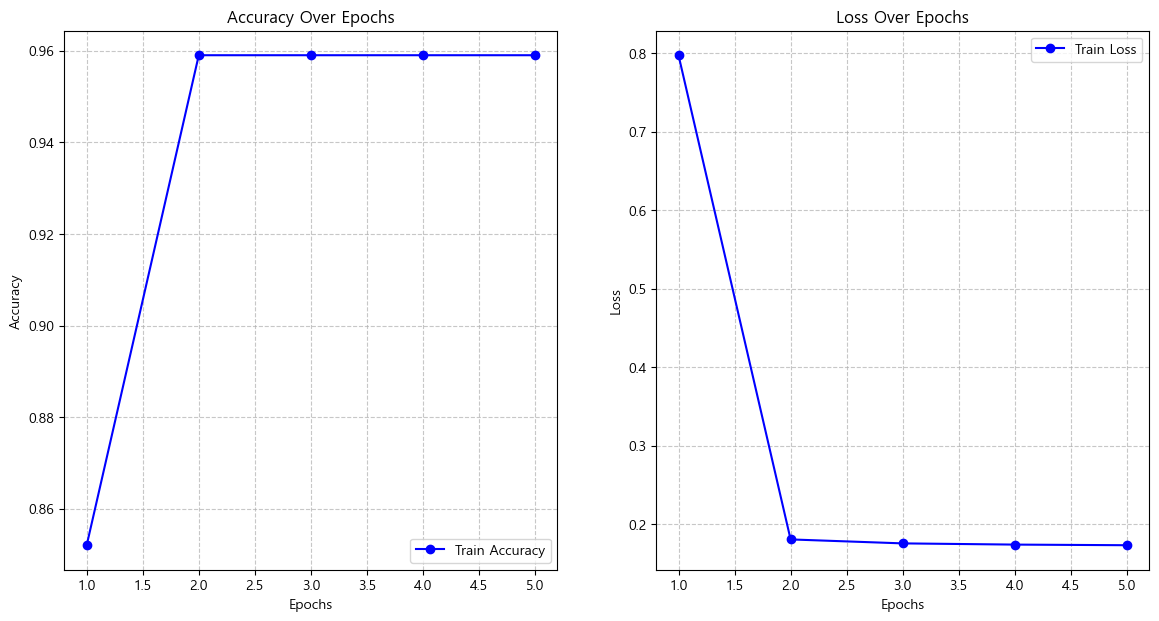

In [40]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 7))

# Accuracy 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_list, marker='o', linestyle='-', color='b', label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_list, marker='o', linestyle='-', color='b', label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

8. 모델 평가 및 정확도 계산

In [42]:
test_acc_list = []
test_loss_list = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)

        test_loss_list.append(loss.item())

        _, preds = torch.max(outputs, dim=1)
        correct_predictions = torch.sum(preds == labels)
        total_predictions = labels.size(0)

        accuracy = correct_predictions.double() / total_predictions
        test_acc_list.append(accuracy.item())

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


9. 예측 결과 추가 및 저장

In [44]:
def predict_labels(data_loader):
    model.eval()
    all_texts = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['label'].cpu().numpy())

    return all_labels, all_preds

In [45]:
# Train 데이터에 대해 예측
train_labels, train_preds = predict_labels(train_loader)

Predicting: 100%|██████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.56it/s]


In [46]:
# Test 데이터에 대해 예측
test_labels, test_preds = predict_labels(test_loader)

Predicting: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.99it/s]


In [47]:
# DataFrame에 예측 결과 추가
train_df['predicted_label'] = train_preds
test_df['predicted_label'] = test_preds

In [48]:
# 평가의견_label 및 predicted_label 환원
train_df['평가의견_label'] = train_df['평가의견_label'].map({0: -1, 1: 0, 2: 1})
test_df['평가의견_label'] = test_df['평가의견_label'].map({0: -1, 1: 0, 2: 1})
train_df['predicted_label'] = train_df['predicted_label'].map({0: -1, 1: 0, 2: 1})
test_df['predicted_label'] = test_df['predicted_label'].map({0: -1, 1: 0, 2: 1})

In [49]:
train_df

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt,제목_세부내용_전처리후_Hannanum,제목_세부내용_전처리후_Kkma,제목_세부내용_전처리후_Komoran,제목_세부내용_전처리후_kiwi,제목_세부내용_전처리후_Komoran_명사,평가의견_label,predicted_label
917,2024-03-14,삼성전자,005930,1Q24 메모리 흑자전환 예상,"100,000",매수,한동희,SK증권,삼성전자(005930) 1Q24 메모리 흑자전환 예상1Q24 메모리 흑자전환 예상,,1Q24 메모리 흑자전환 예상,1 Q 24 메모리 흑자 전환 예상,1Q24 메모리 흑자전환 예상,1 Q 24 메 리 흑자 전환 예상,1 Q 24 메모리 흑자 전환 예상,24 메모리 흑자 전환 예상,24 메모리 흑자 전환 예상,1,1
289,2018-10-08,삼성전자,005930,사상 최고 실적 vs 불확실한 매크로,"57,000",Buy,이승우,유진투자증권,삼성전자(005930)사상 최고 실적 vs. 불확실한 매크로삼성전자(005930)...,사상 최고 실적 vs. 불확실한 매크로 사상 최고 실적 vs. 불확실한 매크로,사상 최고 실적 vs 불확실한 매크로 사상 최고 실적 vs. 불확실한 매크로 사상 ...,사상 최고 실적 vs 불확실한 매크로 사상 최고 실적 vs 불확실한 매크로 사상 최...,사상 최고 실적 vs 불확실 ㄴ 매크로 사상 최고 실적 vs 불확실 ㄴ 매크로 사상...,사상 최고 실적 vs 불확실 ㄴ 매크로 사상 최고 실적 vs 불확실 ㄴ 매크로 사상...,사상 최고 실적 vs 불 확실 ㄴ 매크로 사상 최고 실적 vs 불 확실 ㄴ 매크로 ...,사상 최고 실적 vs 매크로 사상 최고 실적 vs. 매크로 사상 최고 실적 vs. 매크로,사상 최고 실적 매크로 사상 최고 실적 매크로 사상 최고 실적 매크로,1,1
842,2022-06-20,삼성전자,005930,점점 더 거세지는 매크로 역풍,"79,000",Buy,이승우,유진투자증권,삼성전자(005930) 점점 더 거세지는 매크로 역풍What’s New : 하이 인...,What s New 하이 인플레이션과 자이언트 스텝 2Q Preview 세트 사업...,점점 더 거세지는 매크로 역풍 What s New 하이 인플레이션과 자이언트 스텝 ...,점점 더 거세지는 매크로 역풍 What s New 하이 인플레이션 자이언트 스텝 2...,점점 더 거세 지 는 매크로 역풍 What s New 인플레이션 자이언트 스텝 2Q...,점점 더 거세 지 는 매크로 역풍 What s New 하이 인플레이션 자이언트 스텝...,점점 더 거세 지 는 매크로 역풍 What s New 하이 인플레이션 자이언트 스텝...,거세 매크로 역풍 What New 하이 인플레이션 자이언트 스텝 Preview 세트...,매크로 역풍 하이 인플레이션 자이언트 스텝 세트 사업부 부진 분기 영업 이익 추정 ...,1,1
782,2021-10-12,삼성전자,005930,매크로 우려로 실적 전망 및 목표가 하향,"93,000",Buy,이승우,유진투자증권,삼성전자(005930)매크로 우려로 실적 전망 및 목표가 하향What’s New: ...,What s New 3 분기 실적은 예상 수준이나 매크로 우려가 높아짐,매크로 우려로 실적 전망 및 목표가 하향 What s New 3 분기 실적은 예상 ...,매크로 우려 실적 전망 목표 하향 What s New 3 분기 실적 은 예상 수준 ...,매크로 우려 실적 전망 목표 하향 What s New 3 분기 실적 은 예상 수준 ...,매크로 우려 실적 전망 목표 하향 What s New 3 분기 실적 은 예상 수준 ...,매크로 우려 실적 전망 목표 하향 What s New 3 분기 실적 은 예상 수준 ...,매크로 우려 실적 전망 목표 하향 What New 분기 실적 예상 수준 매크로 우려,매크로 우려 실적 전망 목표 하향 분기 실적 예상 수준 매크로 우려,1,1
872,2023-01-09,삼성전자,005930,4Q22 잠정실적 리뷰,"82,000",Buy,김광진,한화투자증권,삼성전자(005930) 4Q22 잠정실적 리뷰4Q22 잠정실적 Review : 전 ...,4Q22 잠정실적 Review 전 사업부 기대치 하회 1Q23 실적 부진 지속 예상,4Q22 잠정실적 리뷰 4Q22 잠정실적 Review 전 사업부 기대치 하회 1Q2...,4 Q 22 잠정 실적 리뷰 4 Q 22 잠정 실적 Review 전 사업 부 기 대...,4Q22 잠정실적 리뷰 4Q22 잠정실적 Review 전 사업부 기대치 하회 1Q2...,4 Q 22 잠정 실적 리뷰 4 Q 22 잠 정실 적 Review 전 사업부 기대치...,4 Q 22 잠정 실적 리뷰 4 Q 22 잠정 실적 Review 전 사업부 기대 지...,22 잠정 실적 리뷰 22 잠정 실적 Review 사업부 기대치 하회 23 실적 부...,22 잠정 실적 리뷰 22 잠정 실적 사업부 기대 하회 23 실적 부진 지속 예상,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,2022-02-09,삼성전자,005930,에게필요한것은,"93,000",Buy,이승우,유진투자증권,삼성전자(005930)삼성전자에게필요한것은?삼성전자(005930)삼성전자에게필요한것은?,,에게필요한것은,필요한것은,에게필요한것 은,에게필요한것은,필요 ㄴ 은,필요,필요,1,1
516,2019-11-01,삼성전자,005930,매력 대비 아쉬운 영업가치,"60,000",Buy,"김선우,서승연",메리츠종금증권,삼성전자(005930)매력 대비 아쉬운 영업가치매력 대비 아쉬운 영업가치,,매력 대비 아쉬운 영업가치,매력 대비 아쉬운 영업 가치,매력 대비 아쉽 은 영업가치,매력 대비 아쉽 ㄴ 영업 가치,매력 대비 아쉽 ㄴ 영업 가치,매력 대비 아쉽 영업 가치,매력 대비 영업 가치,1,1
694,2021-01-04,삼성전자,005930,DRAM 가격 전망치 상향 조정,"100,000",Buy,박유악,키움증권,"삼성전자(005930)DRAM 가격 전망치 상향 조정4Q20 영업이익 9.2조원, ...",4Q20 영업이익 9.2조원 세트 부문 부진 예상 1Q21 영업이익 8조원 분기 ...,DRAM 가격 전망치 상향 조정 4Q20 영업이익 9.2조원 세트 부문 부진 예상 ...,DRAM 가격 전 망치 상향 조정 4 Q 20 영업 이익 9.2조원 세트 부문 부진...,DRAM 가격 전망치 상향 조정 4Q20 영업이익 9.2조원 세트 부문 부진 예상 ...,DRAM 가격 전망 지 상향 조정 4 Q 20 영업 이익 9.2 조 원 세트 부문 ...,DRAM 가격 전망 지 상향 조정 4 Q 20 영업 이익 9 2 조 원 세트 부문 ...,DRAM 가격 전망 상향 조정 20 영업 이익 9.2 세트 부문 부진 예상 21 영...,가격 전망 상향 조정 20 영업 이익 원 세트 부문 부진 예상 21 영업 이익 원 ...,1,1
818,2022-01-28,삼성전자,005930,4Q21 실적발표 자료 하이라이트,0,-,김선우,메리츠증권,삼성전자(005930)4Q21 실적발표 자료 하이라이트4Q21 실적발표 자료 하이라이트,,4Q21 실적발표 자료 하이라이트,4 Q 21 실적 발표 자료 하이라이트,4Q21 실적발표 자료 하이라이트,4 Q 21 실적 발표 자료 하이라이트,4 Q 21 실적 발표 자료 하이라이트,21 실적 발표 자료 하이라이트,21 실적 발표 자료 하이라이트,0,1


In [50]:
test_df

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt,제목_세부내용_전처리후_Hannanum,제목_세부내용_전처리후_Kkma,제목_세부내용_전처리후_Komoran,제목_세부내용_전처리후_kiwi,제목_세부내용_전처리후_Komoran_명사,평가의견_label,predicted_label
405,2019-03-27,삼성전자,005930,큰 방향의 중심에 있다,"52,000",Buy,노근창,현대차투자증권,삼성전자(005930)큰 방향의 중심에 있다큰 방향의 중심에 있다,,큰 방향의 중심에 있다,큰 방향 중심,크 ㄴ 방향 중심 있 다,크 ㄴ 방향 중심 있 다,크 ㄴ 방향 중심 있 다,방향 중심,방향 중심,1,1
593,2020-05-04,삼성전자,005930,보수적 가이던스 제시했으나 장기적으로는 긍정적,"60,000",Buy,이승우,유진투자증권,"삼성전자(005930)보수적 가이던스 제시했으나, 장기적으로는 긍정적 1Q Rev...",1Q Review 영업이익 6.45조원 불확실성에도 선전 2Q 전망 영업이익 6...,보수적 가이던스 제시했으나 장기적으로는 긍정적 1Q Review 영업이익 6.45조...,보수 적 가이던스 제시 했으나 장기 적 으로는 긍정 적 1 Q Review 영업 이...,보수적 가이던스 제시 었으나 장기적 으로는 긍정적 1Q Review 영업이익 6. ...,보수적 가이 던스 제시 었 으나 장기적 는 긍정적 1 Q Review 영업 이익 6...,보수 적 가이던스 제시 았 으나 장기 적 는 긍정 적 1 Q Review 영업 이익...,보수 가이던스 제시 장기 긍정 Review 영업 이익 6.45 선전 전망 영업 이익...,보수 가이던스 제시 장기 긍정 영업 이익 원 불확실성 선전 전망 영업 이익 원 감 ...,1,1
357,2019-01-09,삼성전자,005930,수요 급감 속의 실적 Shock,"50,000",Buy,박유악,키움증권,삼성전자(005930)수요 급감 속의 실적 Shock수요 급감 속의 실적 Shock,,수요 급감 속의 실적 Shock,수요 급감 속 실적 Shock,수요 급감 속 실적 Shock,수요 급감 속 실적 Shock,수요 급감 속 실적 Shock,수요 급감 실적 Shock,수요 급감 속 실적,1,1
669,2020-10-30,삼성전자,005930,투자에 대한 시각을 DRAM으로 옮겨야 할 시기,"75,000",Buy,박유악,키움증권,삼성전자(005930)투자에 대한 시각을 DRAM으로 옮겨야 할 시기투자에 대한 시...,,투자에 대한 시각을 DRAM으로 옮겨야 할 시기,투자 대한 DRAM 옮겨야 할 시기,투자 대하 ㄴ DRAM 옮기 어야 ㄹ 시기,투자 대하 ㄴ DRAM 옮기 어야 ㄹ 시기,투자 대하 ㄴ DRAM 옮기 어야 ㄹ 시기,투자 DRAM 시기,투자 시기,1,1
204,2018-06-11,삼성전자,005930,전자도 어쩔 수 없는 스마트폰 시장,"68,000",Buy,어규진,이베스트증권,삼성전자(005930)전자도 어쩔 수 없는 스마트폰 시장전자도 어쩔 수 없는 스마트...,,전자도 어쩔 수 없는 스마트폰 시장,도 어쩔 수 없는 스마트폰 시장,도 어쩌 ㄹ 수 없 는 스마트폰 시장,도 어쩌 ㄹ 수 없 는 스마트 폰 시장,도 어쩌 ㄹ 수 없 는 스마트폰 시장,스마트폰 시장,수 스마트폰 시장,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,2021-10-12,삼성전자,005930,우려했던 NAND의 업황 둔화 가시화,"95,000",Buy,박유악,키움증권,삼성전자(005930)우려했던 NAND의 업황 둔화 가시화우려했던 NAND의 업황 ...,,우려했던 NAND의 업황 둔화 가시화,우려 했던 NAND 업황 둔화 가시 화,우 리어 었던 NAND 업황 둔화 가시화,우려 었 던 NAND 업 황 둔화 가시화,우려 았 던 NAND 업황 둔화 가시 화,우려 NAND 업황 둔화 가시,우려 업황 둔화 가시,1,1
247,2018-08-01,삼성전자,005930,2Q18 실적 컨퍼런스 콜이 주는 Implication,"76,000",Buy,이재윤,유안타증권,삼성전자(005930)2Q18 실적 컨퍼런스 콜이 주는 Implication2Q18...,,2Q18 실적 컨퍼런스 콜이 주는 Implication,2 Q 18 실적 컨퍼런스 콜 주는 Implication,2Q18 실적 컨퍼런스 콜 주 는 Implication,2 Q 18 실적 컨퍼런스 콜 줄 는 Implication,2 Q 18 실적 컨퍼런스 콜 주 는 Implication,18 실적 컨퍼런스 Implication,18 실적 컨퍼런스 콜,1,1
527,2019-11-19,삼성전자,005930,한고비넘어두개의선물,"63,000",Buy,김선우,메리츠종금증권,삼성전자(005930)한고비넘어두개의선물한고비넘어두개의선물,,한고비넘어두개의선물,한고비 넘어 두 개 선물,한고비넘어두개의선물,한고비 넘 두 개의 선물,한고비 넘 어두 개의 선물,고비 선물,한고비 개의 선물,1,1
751,2021-06-24,삼성전자,005930,단기 실적 모멘텀 vs 4Q21 이후 우려 요인,"107,000",Buy,"이재윤,백길현",유안타증권,삼성전자(005930)단기 실적 모멘텀 vs. 4Q21 이후 우려 요인단기 실적 모...,단기 실적 모멘텀 vs. 4Q21 이후 우려 요인단기 실적 모멘텀 vs. 4Q21...,단기 실적 모멘텀 vs 4Q21 이후 우려 요인 단기 실적 모멘텀 vs. 4Q21 ...,단기 실적 모멘텀 vs 4 Q 21 이후 우려 요인 단기 실적 모멘텀 vs 4 Q ...,단기 실적 모멘텀 vs 4Q21 이후 우려 요 ㄴ 단기 실적 모멘텀 vs 4Q21 ...,단기 실적 모멘텀 vs 4 Q 21 이후 우려 요인 단기 실적 모멘텀 vs 4 Q ...,단기 실적 모멘텀 vs 4 Q 21 이후 우려 요인 단기 실적 모멘텀 vs 4 Q ...,단기 실적 모멘텀 vs 21 이후 우려 요인 단기 실적 모멘텀 vs. 21 이후 우...,단기 실적 모멘텀 21 이후 우려 요인 단기 실적 모멘텀 21 이후 우려 요인 단기...,1,1


10. 감정 분석을 위한 KoFinBERT Sentiment score 산출

In [52]:
text_classifier = TextClassificationPipeline(
    tokenizer=tokenizer,
    model=AutoModelForSequenceClassification.from_pretrained("kwoncho/KoFinBERT"),  # Load original model
    top_k=None,  # 모든 레이블의 확률 반환
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

In [53]:
predicted_train_scores = []
for text in train_df['제목_세부내용_전처리후_Hannanum'] :
    # 감정 분석 수행
    prediction = text_classifier(text)
    
    # 레이블을 숫자 값으로 매핑
    label_mapping = {
        'positive': 1,
        'neutral': 0,
        'negative': -1
    }
    
    # 연속적인 점수 직접 계산
    score = 0
    for item in prediction[0]:
        label = item['label']
        prob = item['score']
        score += label_mapping[label] * prob

    predicted_train_scores.append(score)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [54]:
predicted_test_scores = []
for text in test_df['제목_세부내용_전처리후_Hannanum'] :
    # 감정 분석 수행
    prediction = text_classifier(text)
    
    # 레이블을 숫자 값으로 매핑
    label_mapping = {
        'positive': 1,
        'neutral': 0,
        'negative': -1
    }
    
    # 연속적인 점수 직접 계산
    score = 0
    for item in prediction[0]:
        label = item['label']
        prob = item['score']
        score += label_mapping[label] * prob
    predicted_test_scores.append(score)

In [55]:
predicted_train_scores

[0.9969551096437499,
 -0.0005655178101733327,
 -0.9959589911159128,
 -0.9950367137789726,
 -0.9957253654720262,
 0.9877976074349135,
 -0.00021444086451083422,
 -0.9813899351283908,
 -0.9486013012938201,
 0.996555614634417,
 -0.00039926532190293074,
 0.9673196811927482,
 -0.9959118478000164,
 0.9958904221421108,
 -0.00022646988509222865,
 0.0011094150831922889,
 0.24541597708594054,
 0.47495136596262455,
 0.9969387849560007,
 0.0015934404800646007,
 0.002733362664002925,
 0.9962470572208986,
 -0.9957086051581427,
 0.9962273690616712,
 -0.989469169639051,
 0.9960381335695274,
 0.9970096533652395,
 0.0010562028910499066,
 0.9901688611134887,
 0.8450437212595716,
 8.274492574855685e-05,
 0.0007517291815020144,
 0.9970427607186139,
 0.9968487395672128,
 0.11855866602854803,
 -0.9953443940030411,
 -0.00017648941138759255,
 0.390427915379405,
 0.9957872162922285,
 0.9846936106332578,
 0.9857865881058387,
 -0.9958651787601411,
 -0.9429623577743769,
 -0.0035411384887993336,
 0.9959830893203616,

In [56]:
# DataFrame에 감정 분석 결과 추가
train_df['KoFinBERT_Sentiment'] = predicted_train_scores
test_df['KoFinBERT_Sentiment'] = predicted_test_scores

In [57]:
# train_df와 test_df를 합쳐서 저장
combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [58]:
combined_df = combined_df.sort_values(by=['작성일', '작성기관'])

In [59]:
combined_df

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt,제목_세부내용_전처리후_Hannanum,제목_세부내용_전처리후_Kkma,제목_세부내용_전처리후_Komoran,제목_세부내용_전처리후_kiwi,제목_세부내용_전처리후_Komoran_명사,평가의견_label,predicted_label,KoFinBERT_Sentiment
232,2017-09-06,삼성전자,005930,조정의 빌미는 사라지고 있나,"2,800,000",Buy,황민성,삼성증권,삼성전자(005930)조정의 빌미는 사라지고 있나?반도체 혁신으로 메모리 반도체 제...,반도체 혁신으로 메모리 반도체 제값 받기는 진행 중. 매수의견과 목표가 280만...,조정의 빌미는 사라지고 있나 반도체 혁신으로 메모리 반도체 제값 받기는 진행 중. ...,조정 빌 미는 사라지고 있나 반도체 혁신 메모리 반도체 값 받기는 진행 중 수 의견...,조정 빌미 는 사라지 고 있 반도체 혁신 메모리 반도체 제값 받 기 는 진행 중 매...,조정 빌미 는 사라지 고 있 반 도 체 혁신 메모리 반도체 제값 받 기 는 진행 중...,조정 빌미 는 사라지 고 있 반도체 혁신 메모리 반도체 제값 받 기 는 진행 중 매...,조정 빌미 반도체 혁신 메모리 반도체 제값 진행 매수 의견 목표 280 유지,조정 빌미 반도체 혁신 메모리 반도체 제값 진행 중 매수 의견 목표 만원 유지,1,1,0.996509
834,2017-09-08,삼성전자,005930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,삼성전자(005930)실적 성장 재개와 함께 강화되는 주주환원시장 기대치를 소폭 능...,시장 기대치를 소폭 능가하는 3Q17 영업이익 14.3조원 전망 지속 유지 4Q1...,실적 성장 재개와 함께 강화되는 주주환원 시장 기대치를 소폭 능가하는 3Q17 영업...,실적 성장 재개 강화 되는 주주 환원 시장 기 대치 소 폭 능가 하는 3 Q 17 ...,실적 성장 재개 강화 되 는 주주환원 시장 기대치 소폭 능가 는 3Q17 영업이익 ...,실적 성장 재개 강화 되 는 주주 환원 시장 기대치 소폭 능가 는 3 Q 17 영업...,실적 성장 재개 강화 되 는 주주 환원 시장 기대치 소폭 능가 는 3 Q 17 영업...,실적 성장 재개 강화 주주 환원 시장 기대치 소폭 능가 17 영업 이익 14.3 전...,실적 성장 재개 강화 주주 환원 시장 기대치 소폭 능가 17 영업 이익 원 전망 지...,1,1,0.996725
161,2017-09-08,삼성전자,005930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,삼성전자(005930)3분기 증익을 예상합니다!3분기 영업이익 14.3조원 전망,3분기 영업이익 14.3조원 전망,3분기 증익을 예상합니다 3분기 영업이익 14.3조원 전망,3분 기 증익 예상 합니다 3분 기 영업 이익 14.3조원 전망,3분기 증익 예상 ㅂ니다 3분기 영업이익 14. 3조원 전망,3 분기 증익 예상 ㅂ니다 3 분기 영업 이익 14.3 조 원 전망,3 분기 증 익 예상 ㅂ니다 3 분기 영업 이익 14 3 조 원 전망,분기 예상 분기 영업 이익 14.3 전망,분기 증 익 예상 분기 영업 이익 원 전망,1,1,0.992771
675,2017-09-08,삼성전자,005930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,삼성전자(005930)3분기 감익 우려 해소 기대4분기 서프라이즈 실적 기대,4분기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3분 기 감익 우려 해소 기대 4분 기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3 분기 감익 우려 해소 기대 4 분기 서 프라이 즈 실적 기대,3 분기 감 익 우려 해소 기대 4 분기 서프라이즈 실적 기대,분기 우려 해소 기대 분기 서프라이즈 실적 기대,분기 감 익 우려 해소 기대 분기 서프라이즈 실적 기대,1,1,0.996760
900,2017-09-11,삼성전자,005930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,"삼성전자(005930)3Q17 영업이익 총 15조원, 반도체 10조원 전망3Q17 ...",3Q17 영업이익 15조원 시장 기대치 상회할 전망,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15조원 반도체 10조원 전망 3 Q 17 영업 이익 1...,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15 조 원 반도체 10 조 원 전망 3 Q 17 영업 ...,3 Q 17 영업 이익 총 15 조 원 반도체 10 조 원 전망 3 Q 17 영업 ...,17 영업 이익 15 반도체 10 전망 17 영업 이익 15 시장 기대치 상회 전망,17 영업 이익 원 반도체 원 전망 17 영업 이익 원 시장 기대 상회 전망,1,1,0.996863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,2024-08-01,삼성전자,005930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,,메모리반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리반도체 수익성 개 선 본격화,메모리 반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리 반도체 수익 개선 본격,메모리 반도체 수익 개선,1,1,0.817023
48,2024-08-01,삼성전자,005930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,,TSMC와의 시가총액 격차를 좁혀나 갈 시간,TSMC 와의 시가총액 격차 좁혀나 갈,TSMC 와의 시가총액 격차 좁히 ㄹ,TSMC 와의 시가 총액 격차 좁히 ㄹ,TSMC 시가총액 격차 좁히 ㄹ,TSMC 시가 총액 격차,시가총액 격차,1,1,0.003352
61,2024-08-01,삼성전자,005930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,경쟁 심화 예상,1,1,-0.995274
147,2024-08-01,삼성전자,005930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...,여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주가여전히 강력한 AI발...,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가 여전히 강력한 AI발 ...,강력한 AI 발 수요 조 정기 거치 며 더욱 편해진 주가 강력한 AI 발 수요 조 ...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 편하 지 ㄴ 주 강력 ㄴ AI 발 수요...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 펴 ㄴ 해진 주가 강력 ㄴ AI 발 수...,강력 ㄴ AI 발 수요 조정 기 거치 며 더욱 편 해진 주가 강력 ㄴ AI 발 수요...,AI 수요 조정기 편하 AI 수요 조정기 편하 AI 수요 조정기 편하 주가,발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가,1,1,0.002774


In [60]:
combined_df.to_excel('./Text_Data/한경_리포트_데이터_기업_SEC_Hannanum_KoFinBERT.xlsx', index=False)

여기서부터 소수점 1자리로 처리하기 위한 코드

In [6]:
# EXCEL파일 읽기
file_path = './Text_Data/한경_리포트_데이터_기업_SEC_Hannanum_KoFinBERT.xlsx'
combined_df = pd.read_excel(file_path, converters={'뉴스 식별자': str})  # '뉴스 식별자'는 해당 열의 실제 이름으로 대체

In [8]:
combined_df

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt,제목_세부내용_전처리후_Hannanum,제목_세부내용_전처리후_Kkma,제목_세부내용_전처리후_Komoran,제목_세부내용_전처리후_kiwi,제목_세부내용_전처리후_Komoran_명사,평가의견_label,predicted_label,KoFinBERT_Sentiment
0,2017-09-06,삼성전자,5930,조정의 빌미는 사라지고 있나,"2,800,000",Buy,황민성,삼성증권,삼성전자(005930)조정의 빌미는 사라지고 있나?반도체 혁신으로 메모리 반도체 제...,반도체 혁신으로 메모리 반도체 제값 받기는 진행 중. 매수의견과 목표가 280만...,조정의 빌미는 사라지고 있나 반도체 혁신으로 메모리 반도체 제값 받기는 진행 중. ...,조정 빌 미는 사라지고 있나 반도체 혁신 메모리 반도체 값 받기는 진행 중 수 의견...,조정 빌미 는 사라지 고 있 반도체 혁신 메모리 반도체 제값 받 기 는 진행 중 매...,조정 빌미 는 사라지 고 있 반 도 체 혁신 메모리 반도체 제값 받 기 는 진행 중...,조정 빌미 는 사라지 고 있 반도체 혁신 메모리 반도체 제값 받 기 는 진행 중 매...,조정 빌미 반도체 혁신 메모리 반도체 제값 진행 매수 의견 목표 280 유지,조정 빌미 반도체 혁신 메모리 반도체 제값 진행 중 매수 의견 목표 만원 유지,1,1,0.996509
1,2017-09-08,삼성전자,5930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,삼성전자(005930)실적 성장 재개와 함께 강화되는 주주환원시장 기대치를 소폭 능...,시장 기대치를 소폭 능가하는 3Q17 영업이익 14.3조원 전망 지속 유지 4Q1...,실적 성장 재개와 함께 강화되는 주주환원 시장 기대치를 소폭 능가하는 3Q17 영업...,실적 성장 재개 강화 되는 주주 환원 시장 기 대치 소 폭 능가 하는 3 Q 17 ...,실적 성장 재개 강화 되 는 주주환원 시장 기대치 소폭 능가 는 3Q17 영업이익 ...,실적 성장 재개 강화 되 는 주주 환원 시장 기대치 소폭 능가 는 3 Q 17 영업...,실적 성장 재개 강화 되 는 주주 환원 시장 기대치 소폭 능가 는 3 Q 17 영업...,실적 성장 재개 강화 주주 환원 시장 기대치 소폭 능가 17 영업 이익 14.3 전...,실적 성장 재개 강화 주주 환원 시장 기대치 소폭 능가 17 영업 이익 원 전망 지...,1,1,0.996725
2,2017-09-08,삼성전자,5930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,삼성전자(005930)3분기 증익을 예상합니다!3분기 영업이익 14.3조원 전망,3분기 영업이익 14.3조원 전망,3분기 증익을 예상합니다 3분기 영업이익 14.3조원 전망,3분 기 증익 예상 합니다 3분 기 영업 이익 14.3조원 전망,3분기 증익 예상 ㅂ니다 3분기 영업이익 14. 3조원 전망,3 분기 증익 예상 ㅂ니다 3 분기 영업 이익 14.3 조 원 전망,3 분기 증 익 예상 ㅂ니다 3 분기 영업 이익 14 3 조 원 전망,분기 예상 분기 영업 이익 14.3 전망,분기 증 익 예상 분기 영업 이익 원 전망,1,1,0.992771
3,2017-09-08,삼성전자,5930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,삼성전자(005930)3분기 감익 우려 해소 기대4분기 서프라이즈 실적 기대,4분기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3분 기 감익 우려 해소 기대 4분 기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3 분기 감익 우려 해소 기대 4 분기 서 프라이 즈 실적 기대,3 분기 감 익 우려 해소 기대 4 분기 서프라이즈 실적 기대,분기 우려 해소 기대 분기 서프라이즈 실적 기대,분기 감 익 우려 해소 기대 분기 서프라이즈 실적 기대,1,1,0.996760
4,2017-09-11,삼성전자,5930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,"삼성전자(005930)3Q17 영업이익 총 15조원, 반도체 10조원 전망3Q17 ...",3Q17 영업이익 15조원 시장 기대치 상회할 전망,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15조원 반도체 10조원 전망 3 Q 17 영업 이익 1...,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15 조 원 반도체 10 조 원 전망 3 Q 17 영업 ...,3 Q 17 영업 이익 총 15 조 원 반도체 10 조 원 전망 3 Q 17 영업 ...,17 영업 이익 15 반도체 10 전망 17 영업 이익 15 시장 기대치 상회 전망,17 영업 이익 원 반도체 원 전망 17 영업 이익 원 시장 기대 상회 전망,1,1,0.996863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,2024-08-01,삼성전자,5930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,,메모리반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리반도체 수익성 개 선 본격화,메모리 반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리 반도체 수익 개선 본격,메모리 반도체 수익 개선,1,1,0.817023
943,2024-08-01,삼성전자,5930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,,TSMC와의 시가총액 격차를 좁혀나 갈 시간,TSMC 와의 시가총액 격차 좁혀나 갈,TSMC 와의 시가총액 격차 좁히 ㄹ,TSMC 와의 시가 총액 격차 좁히 ㄹ,TSMC 시가총액 격차 좁히 ㄹ,TSMC 시가 총액 격차,시가총액 격차,1,1,0.003352
944,2024-08-01,삼성전자,5930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,경쟁 심화 예상,1,1,-0.995274
945,2024-08-01,삼성전자,5930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...,여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주가여전히 강력한 AI발...,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가 여전히 강력한 AI발 ...,강력한 AI 발 수요 조 정기 거치 며 더욱 편해진 주가 강력한 AI 발 수요 조 ...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 편하 지 ㄴ 주 강력 ㄴ AI 발 수요...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 펴 ㄴ 해진 주가 강력 ㄴ AI 발 수...,강력 ㄴ AI 발 수요 조정 기 거치 며 더욱 편 해진 주가 강력 ㄴ AI 발 수요...,AI 수요 조정기 편하 AI 수요 조정기 편하 AI 수요 조정기 편하 주가,발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가,1,1,0.002774


In [10]:
combined_df = combined_df[['작성일', '종목명', '종목코드', '제목', '적정가격', '평가의견', '작성자',
                           '작성기관', '제목_세부내용_전처리후_Hannanum', 'KoFinBERT_Sentiment']]

In [12]:
# 소수점 1자리로 반올림
combined_df['KoFinBERT_Sentiment'] = combined_df['KoFinBERT_Sentiment'].round(1)
combined_df['KoFinBERT_Sentiment'] = combined_df['KoFinBERT_Sentiment'].apply(lambda x: 0 if x == -0.0 else x)

C:\Users\dybae\AppData\Local\Temp\ipykernel_40884\3055127085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['KoFinBERT_Sentiment'] = combined_df['KoFinBERT_Sentiment'].round(1)
C:\Users\dybae\AppData\Local\Temp\ipykernel_40884\3055127085.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['KoFinBERT_Sentiment'] = combined_df['KoFinBERT_Sentiment'].apply(lambda x: 0 if x == -0.0 else x)


In [14]:
combined_df

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,제목_세부내용_전처리후_Hannanum,KoFinBERT_Sentiment
0,2017-09-06,삼성전자,5930,조정의 빌미는 사라지고 있나,"2,800,000",Buy,황민성,삼성증권,조정 빌미 는 사라지 고 있 반도체 혁신 메모리 반도체 제값 받 기 는 진행 중 매...,1.0
1,2017-09-08,삼성전자,5930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,실적 성장 재개 강화 되 는 주주환원 시장 기대치 소폭 능가 는 3Q17 영업이익 ...,1.0
2,2017-09-08,삼성전자,5930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,3분기 증익 예상 ㅂ니다 3분기 영업이익 14. 3조원 전망,1.0
3,2017-09-08,삼성전자,5930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,1.0
4,2017-09-11,삼성전자,5930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,1.0
...,...,...,...,...,...,...,...,...,...,...
942,2024-08-01,삼성전자,5930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,메모리반도체 수익성 개 선 본격화,0.8
943,2024-08-01,삼성전자,5930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,TSMC 와의 시가총액 격차 좁히 ㄹ,0.0
944,2024-08-01,삼성전자,5930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,HBM 경쟁 심화 예상,-1.0
945,2024-08-01,삼성전자,5930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 편하 지 ㄴ 주 강력 ㄴ AI 발 수요...,0.0


In [16]:
combined_df.to_excel('./Text_Data/한경_리포트_데이터_기업_SEC_Hannanum_KoFinBERT.xlsx', index=False)

In [18]:
combined_df

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,제목_세부내용_전처리후_Hannanum,KoFinBERT_Sentiment
0,2017-09-06,삼성전자,5930,조정의 빌미는 사라지고 있나,"2,800,000",Buy,황민성,삼성증권,조정 빌미 는 사라지 고 있 반도체 혁신 메모리 반도체 제값 받 기 는 진행 중 매...,1.0
1,2017-09-08,삼성전자,5930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,실적 성장 재개 강화 되 는 주주환원 시장 기대치 소폭 능가 는 3Q17 영업이익 ...,1.0
2,2017-09-08,삼성전자,5930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,3분기 증익 예상 ㅂ니다 3분기 영업이익 14. 3조원 전망,1.0
3,2017-09-08,삼성전자,5930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,1.0
4,2017-09-11,삼성전자,5930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,1.0
...,...,...,...,...,...,...,...,...,...,...
942,2024-08-01,삼성전자,5930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,메모리반도체 수익성 개 선 본격화,0.8
943,2024-08-01,삼성전자,5930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,TSMC 와의 시가총액 격차 좁히 ㄹ,0.0
944,2024-08-01,삼성전자,5930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,HBM 경쟁 심화 예상,-1.0
945,2024-08-01,삼성전자,5930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 편하 지 ㄴ 주 강력 ㄴ AI 발 수요...,0.0


In [20]:
combined_df = combined_df.groupby('작성일', as_index=False)['KoFinBERT_Sentiment'].mean()
# 소수점 1자리로 반올림
combined_df['KoFinBERT_Sentiment'] = combined_df['KoFinBERT_Sentiment'].round(1)
combined_df['KoFinBERT_Sentiment'] = combined_df['KoFinBERT_Sentiment'].apply(lambda x: 0 if x == -0.0 else x)
# 결과 확인
combined_df

,작성일,KoFinBERT_Sentiment
0,2017-09-06,1.0
1,2017-09-08,1.0
2,2017-09-11,1.0
3,2017-09-12,1.0
4,2017-09-13,1.0
...,...,...
425,2024-06-24,0.0
426,2024-07-02,0.5
427,2024-07-05,0.0
428,2024-08-01,0.2


In [22]:
combined_df.to_excel('./Text_Data/한경_리포트_데이터_기업_SEC_Hannanum_KoFinBERT_daily.xlsx', index=False)